# M3 - Imagen

Este módulo es el núcleo del sistema de visión artificial. Operativamente está compuesto por cuatro bloques funcionales que siguen el flujo recogido en la siguiente imagen:

```{figure} .././assets/Modulo-3.png
:name: Figura_WP1_imagen.6
:alt: UML del modúlo de visión artificial
:width: 25%
:align: center

Bloques funcionales del módulo de imagen (visión artificial)
```
El motor de este módulo se sustenta sobre el algoritmo GrabCut. GrabCut es un método semiautomático para segmentar objetos en una imagen, es decir, para separar una región de interés del resto de la escena. Fue propuesto en 2004 por Rother, Kolmogorov y Blake [[Rother et al., 2004](https://doi.org/10.1145/1015706.1015720)], y se ha convertido en una herramienta clásica en visión por computadora debido a su equilibrio entre precisión y facilidad de uso.

En su planteamiento original, el algoritmo necesita una pequeña intervención del usuario para trazar un rectángulo que contenga aproximadamente el objeto que se desea extraer. A partir de ahí, GrabCut trabaja de forma iterativa para refinar la segmentación sin necesidad de más entradas, aunque también permite correcciones manuales si es necesario.

Matemáticamente, GrabCut modela los colores del objeto (primer plano o foreground) y del entorno (fondo o background) mediante modelos de mezcla gaussiana (GMM, por sus siglas en inglés)[[Bishop, 2006](https://doi.org/10.1007/978-1-4615-7566-5)]. Estos modelos permiten representar distribuciones complejas de color como la combinación de varias campanas gaussianas, cada una capturando un tono o textura característica. Así, en lugar de asumir que todos los píxeles del objeto tienen el mismo color, el GMM reconoce que pueden existir múltiples modos (o grupos) de colores dentro de la misma región.

Además del color, GrabCut también considera la estructura espacial de la imagen: píxeles cercanos tienden a pertenecer a la misma clase. Esta idea se modela mediante un campo aleatorio de Markov (MRF), que penaliza soluciones en las que píxeles vecinos tienen etiquetas muy diferentes sin una justificación clara en los datos (por ejemplo, un cambio brusco de color). De esta forma, se evitan segmentaciones irregulares o con ruido [[Li, 2009](https://doi.org/10.1007/978-1-84882-437-9)].

Todo esto se combina en una función de energía que mide lo “buena” que es una segmentación propuesta. Minimizar esta energía equivale a encontrar la máscara que mejor explica los colores observados (usando los GMMs) y que, al mismo tiempo, sea espacialmente coherente (gracias al MRF).

En el contexto de FLATCLASS este algoritmo se ha adaptado para no contar con intervención humana inicial. Para aislar el objeto de interés (lenguado) se ha usado una cinta transportadora de color azul, cuyo tono varía ligeramente debido a iluminación escasa, no homogénea, sombras, presencia de gotas de agua o textura del material. Dado que el objeto y el fondo tienen colores claramente distintos, y aún asumiendo que el fondo no es uniforme, se puede indicar al algoritmo que el fondo es predominantemente azul y que el objeto (lenguado) ocupa aproximadamente el centro de la imagen.

```{figure} .././assets/P22C-ML_0_calibrated.png
:name: Figura_WP1_imagen.7
:alt: Captura de lenguado
:width: 25%
:align: center

Imagen real de lenguado obtenida con el sistema de captura
```

Esta diferenciación colorimétrica nos permite inicializar automáticamente la máscara GrabCut, etiquetando como "probable fondo" los bordes de la imagen y como "probable primer plano" la región central, al tiempo que se definen en el código tonos de azul como semillas reforzadas para GrabCut.

In [2]:
# 
"""
Pipeline de segmentación (OpenCV + GrabCut) y metrología de lenguado.
Incluye:
  - Prefiltrado (NLMeans + bilateral + CLAHE)
  - Umbral dinámico del azul (HSV) para detectar la cinta y anclar la ROI
  - Semillas reforzadas para GrabCut (BG seguro = azul; PR_FG = no-azul dilatado;
    FG seguro = alto contraste H/S respecto al azul + distance transform)
  - Postproceso morfológico orientado (cierre/apertura)
  - Medición por PCA (longitud, anchura) y área desde el contorno
  - Modo debug (guarda artefactos intermedios)
  - Conversión opcional a mm (get_mm_per_px() o scale.json)

Referencias clave (DOI):
- GrabCut / Graph Cuts: Rother et al. 2004 (10.1145/1015706.1015720), Boykov & Jolly 2001 (10.1109/ICCV.2001.937505)
- NLMeans: Buades et al. 2005 (10.1109/CVPR.2005.38)
- Bilateral: Tomasi & Manduchi 1998 (10.1109/ICCV.1998.710815)
- CLAHE: Zuiderveld 1994 (10.1016/B978-0-12-336156-1.50061-6)
- PCA: Jolliffe & Cadima 2016 (10.1098/rsta.2015.0202)
"""

import cv2
import json
import numpy as np
import pandas as pd
from pathlib import Path

# =========================
# Configuración del pipeline
# =========================
CONFIG = {
    "img_path": "./P22C-ML_0_calibrated.png",
    "out_prefix": "./out/sole_",     # prefijo para salidas (debug/overlay/máscara/csv)
    "pad_roi": 12,                       # padding de la ROI (px)
    # Prefiltrado
    "nlmeans_h": 5,
    "bilateral_d": 9, "bilateral_sigmaC": 50, "bilateral_sigmaS": 50,
    "clahe_clip": 2.0, "clahe_tiles": (8, 8),
    # Umbral dinámico azul
    "blue_sat_min": 80,       # mínimo S para estimar el pico de H
    "blue_half_window": 15,   # ±ΔH alrededor del pico de H
    # Semillas
    "pr_fg_kernel": (7, 19),          # dilatación anisotrópica (W,H) para PR_FG
    "sure_fg_pct_contrast": 70,       # percentil del mapa de contraste H/S
    "sure_fg_pct_dt": 60,             # percentil de distance transform para reforzar FG
    "gc_iters": 12,                   # iteraciones de GrabCut
    # Postproceso
    "post_close_kernel": (9, 13),
    # Métrica (opcional)
    "scale_json": "./calibracion_px_mm.json",  # {"mm_per_px": 0.1234}
    # Debug
    "debug": True
}

# =========================
# Utilidades
# =========================
def save_img(name: str, img) -> str:
    """Guarda una imagen (BGR o 1 canal) con el prefijo de salida y devuelve su ruta."""
    p = CONFIG["out_prefix"] + name
    if img.ndim == 2:  # gris
        cv2.imwrite(p, img)
    else:
        cv2.imwrite(p, img if img.shape[2] == 3 else img[..., :3])
    return p

def get_scale_mm_per_px() -> float | None:
    """
    Intenta obtener mm/px desde:
    1) función get_mm_per_px() del usuario (si existe),
    2) archivo JSON CONFIG['scale_json'] con {"mm_per_px": valor}.
    """
    # 1) Función del usuario
    try:
        from get_mm_per_px import get_mm_per_px  # type: ignore
        val = float(get_mm_per_px())
        if val > 0:
            return val
    except Exception:
        pass
    # 2) JSON
    p = Path(CONFIG["scale_json"])
    if p.exists():
        try:
            data = json.loads(p.read_text())
            val = float(data.get("mm_per_px", 0))
            if val > 0:
                return val
        except Exception:
            pass
    return None

# =========================
# Bloques del pipeline
# =========================
def prefilter(bgr: np.ndarray) -> np.ndarray:
    """NLMeans + bilateral + CLAHE(V) → BGR prefiltrado."""
    den = cv2.fastNlMeansDenoisingColored(
        bgr, None,
        h=CONFIG["nlmeans_h"], hColor=CONFIG["nlmeans_h"],
        templateWindowSize=7, searchWindowSize=21
    )
    den = cv2.bilateralFilter(
        den, d=CONFIG["bilateral_d"],
        sigmaColor=CONFIG["bilateral_sigmaC"], sigmaSpace=CONFIG["bilateral_sigmaS"]
    )
    hsv = cv2.cvtColor(den, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(CONFIG["clahe_clip"], CONFIG["clahe_tiles"])
    v = clahe.apply(v)
    out = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)
    if CONFIG["debug"]:
        save_img("01_prefilter.png", out)
    return out

def dynamic_blue_threshold(hsv: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Calcula [lower, upper] HSV del azul a partir del pico de H en banda central con S>umbral."""
    H, S, _ = cv2.split(hsv)
    Hh, Wh = H.shape
    x1, x2 = int(Wh * 0.32), int(Wh * 0.68)  # banda central para evitar bordes metálicos
    band = H[:, x1:x2]
    band_s = S[:, x1:x2]
    mask_sat = band_s > CONFIG["blue_sat_min"]
    hh = band[mask_sat].flatten()
    if hh.size == 0:
        lower = np.array([95, 100, 30], np.uint8)
        upper = np.array([125, 255, 255], np.uint8)
    else:
        hist = cv2.calcHist([hh.astype(np.uint8)], [0], None, [180], [0, 180]).flatten()
        peak = int(np.argmax(hist))
        hw = CONFIG["blue_half_window"]
        lower = np.array([max(0, peak - hw), 80, 30], np.uint8)
        upper = np.array([min(179, peak + hw), 255, 255], np.uint8)
    return lower, upper

def belt_roi_from_blue(hsv: np.ndarray, lower: np.ndarray, upper: np.ndarray) -> tuple[tuple[int,int,int,int], np.ndarray]:
    """Umbraliza el azul, limpia (open/close) y devuelve (x,y,w,h) de la mayor componente + máscara azul."""
    blue = cv2.inRange(hsv, lower, upper)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blue = cv2.morphologyEx(blue, cv2.MORPH_OPEN, k, iterations=1)
    blue = cv2.morphologyEx(blue, cv2.MORPH_CLOSE, k, iterations=2)
    cnts, _ = cv2.findContours(blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        raise RuntimeError("No se detectó la cinta azul")
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    H, W = blue.shape
    pad = CONFIG["pad_roi"]
    x = max(0, x - pad); y = max(0, y - pad)
    w = min(W - x, w + 2 * pad); h = min(H - y, h + 2 * pad)
    if CONFIG["debug"]:
        save_img("02_blue_mask.png", blue)
        dbg = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        cv2.rectangle(dbg, (x, y), (x + w, y + h), (255, 0, 255), 3)
        save_img("03_roi_debug.png", dbg)
    return (x, y, w, h), blue

def seeds_in_roi(bgr_roi: np.ndarray, lower: np.ndarray, upper: np.ndarray) -> np.ndarray:
    """
    Genera máscara de estados para GrabCut (gc_mask):
      - BG seguro: azul.
      - PR_FG: no-azul dilatado anisotrópicamente (conectar cabeza/cola).
      - FG seguro: no-azul con alto contraste H/S respecto al azul + refuerzo por DT.
    """
    hsv = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2HSV)
    blue = cv2.inRange(hsv, lower, upper)
    not_blue = cv2.bitwise_not(blue)

    # PR_FG (no-azul dilatado verticalmente)
    k_vert = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, CONFIG["pr_fg_kernel"])
    pr_fg = cv2.dilate(not_blue, k_vert, iterations=1)

    # FG seguro: contraste H/S + distance transform
    h, s, _ = cv2.split(hsv)
    belt_h = h[blue > 0].astype(np.float32)
    belt_s = s[blue > 0].astype(np.float32)
    if belt_h.size:
        mu_h, mu_s = float(np.median(belt_h)), float(np.median(belt_s))
        dh = cv2.absdiff(h.astype(np.int16), np.full_like(h, int(mu_h), np.int16)).astype(np.uint8)
        ds = cv2.absdiff(s.astype(np.int16), np.full_like(s, int(mu_s), np.int16)).astype(np.uint8)
        contrast = cv2.addWeighted(dh, 0.7, ds, 0.3, 0)
        thr = int(np.percentile(contrast, CONFIG["sure_fg_pct_contrast"]))
        _, hi = cv2.threshold(contrast, thr, 255, cv2.THRESH_BINARY)
        sure_fg = cv2.bitwise_and(hi, not_blue)
        if CONFIG["debug"]:
            norm_c = contrast.copy()
            cv2.normalize(norm_c, norm_c, 0, 255, cv2.NORM_MINMAX)
            save_img("07_contrast.png", norm_c)
    else:
        sure_fg = cv2.erode(pr_fg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9)), 1)

    dist = cv2.distanceTransform((pr_fg > 0).astype(np.uint8), cv2.DIST_L2, 5)
    if np.any(dist > 0):
        th = np.percentile(dist[dist > 0], CONFIG["sure_fg_pct_dt"])
        sure_fg |= (dist > th).astype(np.uint8) * 255

    # Montaje de gc_mask
    m = 6  # borde ROI como BG
    gc_mask = np.full(blue.shape, cv2.GC_PR_BGD, np.uint8)
    gc_mask[blue > 0] = cv2.GC_BGD
    gc_mask[pr_fg > 0] = cv2.GC_PR_FGD
    gc_mask[sure_fg > 0] = cv2.GC_FGD
    gc_mask[:m, :] = cv2.GC_BGD; gc_mask[-m:, :] = cv2.GC_BGD
    gc_mask[:, :m] = cv2.GC_BGD; gc_mask[:, -m:] = cv2.GC_BGD

    if CONFIG["debug"]:
        save_img("04_pr_fg.png", pr_fg)
        save_img("05_sure_fg.png", sure_fg)
        save_img("06_not_blue.png", not_blue)
        save_img("08_gc_seeds.png", (gc_mask * (255 // 3)).astype(np.uint8))
    return gc_mask

# =========================
# Orquestador
# =========================
def extractor():
    IMG_PATH = CONFIG["img_path"]
    OUT_OVERLAY = CONFIG["out_prefix"] + "overlay_debug.png"
    OUT_MASK = CONFIG["out_prefix"] + "mask_debug.png"
    OUT_CSV = CONFIG["out_prefix"] + "measurements_debug.csv"

    # 1) Carga + prefiltrado
    bgr0 = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
    if bgr0 is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {IMG_PATH}")
    bgr = prefilter(bgr0)

    # 2) Umbral azul dinámico y ROI de la cinta
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    lower, upper = dynamic_blue_threshold(hsv)
    roi, _ = belt_roi_from_blue(hsv, lower, upper)
    x, y, w, h = roi
    crop = bgr[y:y+h, x:x+w].copy()

    # 3) Semillas + GrabCut + postproceso
    gc_mask = seeds_in_roi(crop, lower, upper)
    bg_model = np.zeros((1, 65), np.float64)
    fg_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(crop, gc_mask, None, bg_model, fg_model, CONFIG["gc_iters"], cv2.GC_INIT_WITH_MASK)
    mask_roi = np.where((gc_mask == cv2.GC_FGD) | (gc_mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)
    if CONFIG["debug"]:
        save_img("09_mask_roi_raw.png", (mask_roi * 255))

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, CONFIG["post_close_kernel"])
    mask_roi = cv2.morphologyEx(mask_roi, cv2.MORPH_CLOSE, k, iterations=1)
    mask_roi = cv2.morphologyEx(mask_roi, cv2.MORPH_OPEN,
                                cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=1)

    full = np.zeros(bgr.shape[:2], np.uint8)
    full[y:y+h, x:x+w] = mask_roi

    # 4) Selección de contorno del pez (área + alargamiento)
    cnts, _ = cv2.findContours((full * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        raise RuntimeError("No contornos tras segmentación.")

    def score(c):
        area = cv2.contourArea(c)
        if area < 1500:
            return -1
        (w_, h_) = cv2.minAreaRect(c)[1]
        if w_ == 0 or h_ == 0:
            return -1
        aspect = max(w_, h_) / max(1.0, min(w_, h_))
        return area + 3500.0 * max(0.0, aspect - 1.3)

    cnt = max(cnts, key=score)

    # 5) Medición por PCA + área
    pts = cnt.reshape(-1, 2).astype(np.float32)
    mean, eigvecs, _ = cv2.PCACompute2(pts, mean=None)
    mean = mean.flatten()
    R = np.asarray(eigvecs, np.float32)
    pts_c = pts - mean
    pts_r = pts_c @ R.T
    min_x, max_x = np.min(pts_r[:, 0]), np.max(pts_r[:, 0])
    min_y, max_y = np.min(pts_r[:, 1]), np.max(pts_r[:, 1])
    length_px = float(max_x - min_x)
    width_px = float(max_y - min_y)
    area_px2 = float(cv2.contourArea(cnt))

    # 6) Overlay (perímetro + caja PCA + eje mayor + ROI)
    rgb = cv2.cvtColor(bgr0, cv2.COLOR_BGR2RGB)
    overlay = rgb.copy()
    box_r = np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]], np.float32)
    box_img = (box_r @ R) + mean
    box_img = np.int32(box_img)
    cv2.drawContours(overlay, [cnt], -1, (0, 255, 0), 3)
    cv2.polylines(overlay, [box_img], True, (255, 255, 0), 2)
    i_max = np.argmax(pts_r[:, 0]); i_min = np.argmin(pts_r[:, 0])
    p1 = (np.array([pts_r[i_min, 0], 0.0], np.float32) @ R) + mean
    p2 = (np.array([pts_r[i_max, 0], 0.0], np.float32) @ R) + mean
    cv2.line(overlay, tuple(np.int32(p1)), tuple(np.int32(p2)), (255, 0, 0), 2)
    cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 0, 255), 2)

    # 7) Conversión opcional a mm
    mm_per_px = get_scale_mm_per_px()
    if mm_per_px is not None and mm_per_px > 0:
        length_mm = length_px * mm_per_px
        width_mm = width_px * mm_per_px
        area_mm2 = area_px2 * (mm_per_px ** 2)
    else:
        length_mm = width_mm = area_mm2 = float("nan")

    # 8) Guardado de salidas
    mask_path = save_img("mask_debug.png", (full * 255))
    overlay_path = save_img("overlay_debug.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    df = pd.DataFrame([{
        "image_path": IMG_PATH,
        "roi_x": x, "roi_y": y, "roi_w": w, "roi_h": h,
        "length_px": length_px, "width_px": width_px, "area_px2": area_px2,
        "mm_per_px": (float(mm_per_px) if mm_per_px else float("nan")),
        "length_mm": float(length_mm), "width_mm": float(width_mm), "area_mm2": float(area_mm2)
    }])
    csv_path = CONFIG["out_prefix"] + "measurements_debug.csv"
    df.to_csv(csv_path, index=False)

    return overlay_path, mask_path, csv_path, length_px, width_px, area_px2, mm_per_px, (x, y, w, h)

El algoritmo de visión desarrollado se sustenta sobre una seria de funciones, cada una responsable de resolver el bloque operativo definido en la figura {numref}`Figura_WP1_imagen.6`.

### CONFIG
Este algoritmo los siguientes parámetros de configuración:

- **`img_path` (str).** Ruta absoluta o relativa de la imagen BGR a procesar. Es la fuente de datos del pipeline; debe apuntar a un fichero legible por OpenCV (`cv2.imread`).

- **`out_prefix` (str).** Prefijo de salida para todos los artefactos generados (p. ej., *overlay*, máscara, CSV y, en modo *debug*, máscaras intermedias). Tiene que apuntar a una crapeta física en el sistema de ficheros y permite controlar la organización en disco y evitar colisiones de nombres en ejecuciones sucesivas.

- **`pad_roi` (int, px).** Margen de expansión (*padding*) aplicado al *bounding box* de la cinta detectada en HSV. Aumentarlo garantiza que la ROI cubra totalmente la banda (banda a banda) y pequeñas desalineaciones; valores altos agrandan la región de búsqueda pero pueden introducir más fondo y elevar la complejidad del corte.

- **`nlmeans_h` (float).** Amplitud del término de atenuación en **fast NLMeans**; controla cuánta variación radiométrica se elimina (denoising) sin borrar texturas relevantes. Valores mayores reducen ruido pero pueden suavizar detalles finos del contorno.

- **`bilateral_d` (int), `bilateral_sigmaC` (float), `bilateral_sigmaS` (float).** Parámetros del filtro **bilateral**: diámetro del vecindario (`d`) y desviaciones estándar radiométrica ($\sigma_{\text{Color}}$) y espacial ($\sigma_\text{Space}$). La mayor $\sigma_\text{Color}$ homogeniza intensidades dentro de vecindarios; la mayor $\sigma_\text{Space}$` amplía el soporte espacial. Su efecto es preservar bordes (transiciones pez/fondo) a la vez que suaviza ruido de alta frecuencia.

- **`clahe_clip` (float), `clahe_tiles` (tuple[int,int]).** Parámetros de **CLAHE** sobre el canal V (HSV): el *clip limit* controla la redistribución de histograma (evita sobre-amplificar ruido), y el tamaño de teselas define la granularidad del realce de contraste local. Un `clip` alto realza detalles pero puede introducir artefactos si el SNR es bajo.

- **`blue_sat_min` (int).** Umbral mínimo de saturación (S) para seleccionar píxeles válidos al estimar el pico de H del azul de la cinta. Filtra zonas con baja cromaticidad (sombras/brillos), estabilizando la detección del modo cromático de fondo.

- **`blue_half_window` (int, grados H).** Semiancho $\Delta H$ alrededor del pico de H estimado para construir el rango HSV dinámico del azul:  
  $[H_0-\Delta H,\; H_0+\Delta H]$. Valores mayores toleran variaciones de tono entre cámaras/iluminaciones; excesos pueden incluir azules no deseados y degradar las semillas de fondo.

- **`pr_fg_kernel` (tuple[int,int]).** Tamaño (ancho, alto) del elemento estructurante elíptico para **dilatación anisotrópica** de la máscara *no-azul* (primer plano probable). Un kernel más alto conecta estructuras alargadas en la dirección longitudinal del pez (cabeza/cola), reduciendo cortes en extremos finos; demasiado grande puede unir falsos positivos.

- **`sure_fg_pct_contrast` (int, %).** Percentil aplicado al mapa de contraste cromático (combinación ponderada de distancias en H y S respecto al modo azul) para definir primer plano seguro. Formalmente, el umbral se fija como:
  $
  T \;=\; \operatorname{perc}_p\!\big(C\big),
  $
  donde $C$ es el mapa de contraste y $p$ es el percentil configurado.

- **`sure_fg_pct_dt` (int, %).** Percentil sobre la transformada de distancia del primer plano probable para reforzar el núcleo del pez (píxeles más alejados del fondo). Subirlo prioriza regiones centrales sólidas, útil cuando la cola aparece fragmentada; bajarlo expande el refuerzo hacia periferia con mayor riesgo de fugas.

- **`gc_iters` (int).** Número de iteraciones de GrabCut (ciclos de reestimación GMM + *min-cut*). Más iteraciones permiten convergencia más estable de la energía, a costa de tiempo de cómputo:
  $
  E(L,\theta)\;=\;\sum_i D(\mathbf{x}_i\mid L_i,\theta)\;+\;\lambda\sum_{(i,j)\in\mathcal{N}}V(L_i,L_j).
  $

- **`post_close_kernel` (tuple[int,int]).** Tamaño del elemento estructurante elíptico para el cierre morfológico posterior a GrabCut (seguido de una apertura ligera). Un kernel más largo ayuda a sellar discontinuidades a lo largo del eje del pez (especialmente en la cola); si es excesivo, puede engordar el contorno.

- **`scale_json` (str).** Ruta al fichero opcional `calibration_px_mm.json` con `{"mm_per_px": valor}` para realizar la conversión métrica.

- **`debug` (bool).** Activa el *modo diagnóstico*: guarda en disco los pasos intermedios (prefiltrado, máscara azul, ROI, semillas BG/PR\_FG/FG, contraste H/S, máscara *raw* de GrabCut y máscara final), además del *overlay* y el CSV. Es clave para trazabilidad y *fine-tuning* de hiperparámetros aunque debería desactivarse en producción para minimizar E/S.


### Preprocesado

Este bloque funcional se sustenta sobre las siguientes funciones:

* **prefilter(bgr).** Toma como entrada una imagen BGR (`np.ndarray`) y devuelve una versión prefiltrada en BGR tras aplicar NLMeans (reducción de ruido no local), filtro bilateral (suavizado que preserva bordes) y CLAHE en el canal V (HSV). Su utilidad es mejorar la relación señal-ruido y homogeneizar la iluminación antes de la segmentación, estabilizando los modelos de apariencia usados por GrabCut y reduciendo artefactos de borde; en términos prácticos, atenúa alta frecuencia sin degradar discontinuidades relevantes (cabeza/cola del pez frente a la cinta).

* **dynamic_blue_threshold(hsv).** Recibe una imagen en HSV y retorna dos vectores `lower` y `upper` (umbrales HSV) que acotan dinámicamente el color azul de la cinta. Estima el pico del histograma del canal H en una franja vertical central (filtrada por saturación mínima) y construye un intervalo $[\,H_0\pm\Delta H\,]$. Su utilidad es adaptar la detección del fondo (cinta) a cambios de cámara/iluminación, reforzando la separación fondo (azul) / no-fondo para las semillas de GrabCut.

### Segmentación

* **belt_roi_from_blue(hsv, lower, upper).** Recibe la imagen HSV y los umbrales `lower/upper`; devuelve la ROI de la cinta como tupla `(x, y, w, h)` y la máscara binaria `blue`. Umbraliza el azul, limpia con operaciones morfológicas (apertura/cierre) y toma el *bounding box* de la mayor componente conexa, expandiéndolo con *padding*. Su utilidad es anclar espacialmente el problema: restringe la segmentación a la banda transportadora (banda a banda), evitando que estructuras ajenas (p. ej., metálicas) perturben la optimización.

* **seeds_in_roi(bgr_roi, lower, upper).** Recibe el recorte BGR de la ROI y los umbrales HSV; devuelve `gc_mask`, una máscara de estados entera con etiquetas de GrabCut {BG seguro, PR_BG, PR_FG, FG}. Construye las semillas así: (i) **BG seguro** = píxeles azules; (ii) **PR_FG** = no-azul dilatado con kernel anisotrópico (alto y estrecho) para conectar zonas finas (cola/cabeza); (iii) **FG seguro** = no-azul con alto contraste cromático respecto al azul (combinación de distancias en H y S umbraladas por percentil), reforzado mediante **distance transform** sobre PR_FG; además fija el borde de la ROI como BG. Su utilidad es condicionar favorablemente la minimización de la energía de GrabCut (término de datos GMM + término de suavidad por corte en grafo), reduciendo fugas y pérdidas en extremos.

### Selección y medición

* **extractor().** No recibe argumentos y devuelve: `overlay_path`, `mask_path`, `csv_path` (rutas), `length_px`, `width_px`, `area_px2` (magnitudes en píxeles), `mm_per_px` (si existe) y la `roi` empleada. Orquesta todo el pipeline: carga y prefiltra la imagen; estima el umbral azul dinámico y extrae la ROI de la cinta; genera semillas y ejecuta GrabCut con iteraciones configurables; aplica postproceso morfológico (cierre/apertura); selecciona el contorno del pez por área + alargamiento; calcula **longitud** y **anchura** proyectando el contorno sobre los autovectores de la **PCA** (extensión $\max-\min$ en cada eje) y el **área** con `cv2.contourArea`; finalmente guarda las salidas (overlay, máscara y CSV) y convierte a unidades métricas si hay factor de escala disponible.

### Otras funciones

El pipeline también proporciona algunas funciones auxiliares como:

* **save_img(name, img).** Recibe como entrada un nombre de archivo (`name`, cadena) y una imagen (`img`, `np.ndarray` en BGR o escala de grises); devuelve la ruta (cadena) del fichero grabado en disco bajo el prefijo de salida. Su utilidad es persistir artefactos intermedios y finales —p. ej., máscaras, semillas, overlay— cuando el modo *debug* está activo, proporcionando trazabilidad experimental del pipeline y facilitando la inspección post-hoc de fallos de segmentación o ajustes de parámetros.

* **get_scale_mm_per_px().** No recibe argumentos y devuelve el factor escalar `mm_per_px` (flotante) o `None` si no está disponible. Internamente busca primero una función externa del usuario `get_mm_per_px()` y, en su defecto, un fichero `calibracion_px_mm.json` con la clave `"mm_per_px"`, que debería existir tras haber realizado una calibración. Su utilidad es habilitar la conversión métrica de las magnitudes geométricas estimadas en píxeles —longitud, anchura y área.


Para ejecutar el pipeline basta con:

In [3]:
# === Ejecutar ===
overlay_p, mask_p, csv_p, Lpx, Wpx, Apx2, mmpp, roi = extractor()
print(f"[Áreade interés] ROI: {roi}")
print(f"[Medidas detectadas] L={Lpx:.1f}px  W={Wpx:.1f}px  A={Apx2:.1f}px^2")
if mmpp:
    print(f"[medidas reales] mm/px={mmpp}  L={Lpx*mmpp:.2f} mm  W={Wpx*mmpp:.2f} mm  A={Apx2*(mmpp**2):.2f} mm^2")
print(f"Overlay:   {overlay_p}")
print(f"Máscara:   {mask_p}")
print(f"CSV:       {csv_p}")

[Áreade interés] ROI: (9, 0, 1119, 1080)
[Medidas detectadas] L=745.1px  W=294.4px  A=152192.5px^2
[medidas reales] mm/px=0.05  L=37.25 mm  W=14.72 mm  A=380.48 mm^2
Overlay:   ./out/sole_overlay_debug.png
Máscara:   ./out/sole_mask_debug.png
CSV:       ./out/sole_measurements_debug.csv


En las siguientes imágenes se pueden ver las máscaras aplicadas y el resultado final de detección de la imagen {refnum}`Figura_WP1_imagen.7`

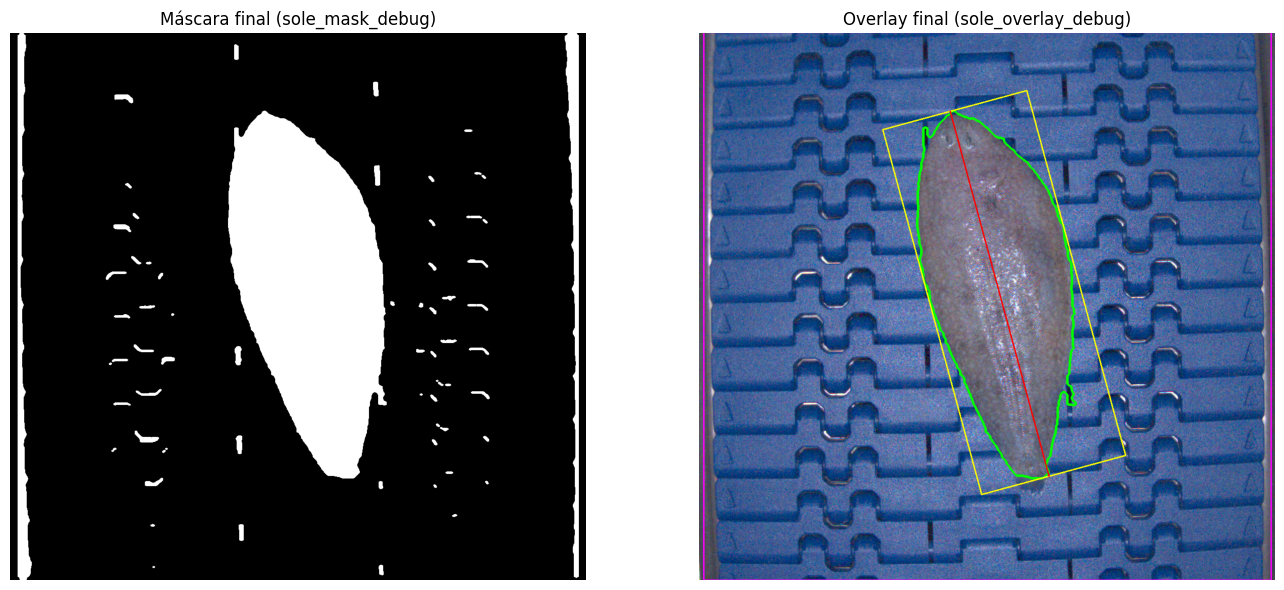

In [4]:
import matplotlib.pyplot as plt

# Cargamos desde las rutas devueltas por run()
mask_img = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)
overlay_bgr = cv2.imread(overlay_p, cv2.IMREAD_COLOR)
overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(mask_img, cmap='gray')
plt.title('Máscara final (sole_mask_debug)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay_rgb)
plt.title('Overlay final (sole_overlay_debug)')
plt.axis('off')

plt.tight_layout()
plt.show()